# Chapter 4 - Modelling Non–Genetic Heterogeneity - Molecular Switches
Presented here is the python code used to generate the results in the Chapter 4 of the thesis. For brevity much of the code is contained within external Python files. This notebook serves as a guide to interact with these files.

The code used here is partially adapted from that used to generate the results in the following publication:

__Nichol, Daniel, et al. "Stochasticity in the genotype-phenotype map: Implications for the robustness and persistence of bet-hedging." Genetics 204.4 (2016): 1523-1539.__

## Prerequisites

In [1]:
from copy import copy
from copy import deepcopy
import glob
import math
from random import random
import sys

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.axes_grid1 import Grid
import numpy as np
import seaborn as sns

import seaborn as sbn
sbn.set(rc={'image.cmap': 'cubehelix'})
sbn.set_style("white")

print "Python version: ", sys.version
print "numpy version: ", np.__version__
print "matplotlib version: ", matplotlib.__version__


#Plotting style variables
linestyles = ['-', '--', '-.',':']
linecols = [sns.xkcd_rgb["pale red"], sns.xkcd_rgb["denim blue"],
            sns.xkcd_rgb["medium green"],sns.xkcd_rgb["black"]]
switchlabs=["DC Switch", "DC Switch - X Biased", 
            "DC Switch - Y Biased", "AM Switch"]

%matplotlib inline

Python version:  2.7.13 |Continuum Analytics, Inc.| (default, Dec 20 2016, 23:05:08) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
numpy version:  1.11.3
matplotlib version:  2.0.2


## Reaction Networks (General Case)
We begin by defining a general purpose reaction networks class that can be used to implement molecular-switch-driven bet-hedging. Note that because this implementation is purposely general it will not be optimised for a specific switch. The necessary code is available in ReactionNetworks.py where a DirectCompetition and ApproximateMajority network are defined.

In [2]:
import reactionNetwork as rn

In [3]:
DC_net = rn.DirectCompetition([1.0,1.0], [30,30])
DCx_net = rn.DirectCompetition([1.1,1.0], [30,30])
DCy_net = rn.DirectCompetition([1.0,1.1], [30,30])
AM_net = rn.ApproximateMajorityNetwork(2, [30,30])
#Example
print DC_net

x y --1.0--> x x 
x y --1.0--> y y 



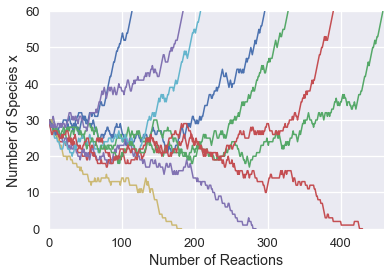

In [4]:
#==============================================================================#
# We can generate a stochastic plot for a network by as follows:
# (Figure 4.2, second row, example)
#
# Stochastic simulations are determined by a Gillespie algorithm.
#==============================================================================#
AM_net.generateStochasticPlot(0, 10)

## Reaction Networks (Specific Cases)
In hedges.py we define optimised look-up tables for the DC, DCx, DCy and AM switches.

In [5]:
import hedges
g_max = 60
DC_hedge = hedges.DC_hedge
DC_hedge_x = hedges.get_DC_hedge(1.1,1.0)
DC_hedge_y = hedges.get_DC_hedge(1.0,1.1)
AM_hedge = hedges.get_AM_hedge(120)

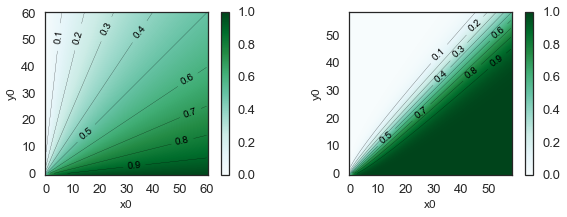

In [6]:
#==============================================================================#
#Figure (4.2, final row, examples)
#==============================================================================#
sbn.set_style("white")
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(121)
seamap = sbn.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, 
                               reverse=True, as_cmap=True)
dc_hm = [[DC_hedge(x,x+y) for x in range(1,62)] for y in range(1,62)]
cax = ax.matshow(dc_hm, cmap='BuGn', origin='lower', vmax=1.0, vmin=0.0, 
                 interpolation='spline16')
fig.colorbar(cax)
ax.xaxis.set_ticks_position('bottom')
cset = plt.contour(dc_hm,np.arange(0.1,1.,0.1),linewidths=.2,colors='k')
plt.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
plt.xlabel("x0", size=12)
plt.ylabel("y0", size=12, rotation=90)
ax = fig.add_subplot(122)
seamap = sbn.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, 
                               reverse=True, as_cmap=True)
am_hm = [[AM_hedge(x,x+y) for x in range(1,60)] for y in range(1,60)]
cax = ax.matshow(am_hm, cmap='BuGn', origin='lower', vmax=1.0, vmin=0.0, 
                 interpolation='spline16')
fig.colorbar(cax)
ax.xaxis.set_ticks_position('bottom')
cset = plt.contour(am_hm,np.arange(0.1,1.,0.1),linewidths=.2,colors='k')
plt.clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
plt.xlabel("x0", size=12)
plt.ylabel("y0", size=12, rotation=90);

## Closely Matching Abritrary $p$
In Figure 4.3 we demonstrate the relationsip between $g_{max}$ and the maximum difference between $p \in [0,1]$ and $q(x_0, y_0)$ for $x_0+y_0<g_{max}$. The following code generates Figure 4.3.


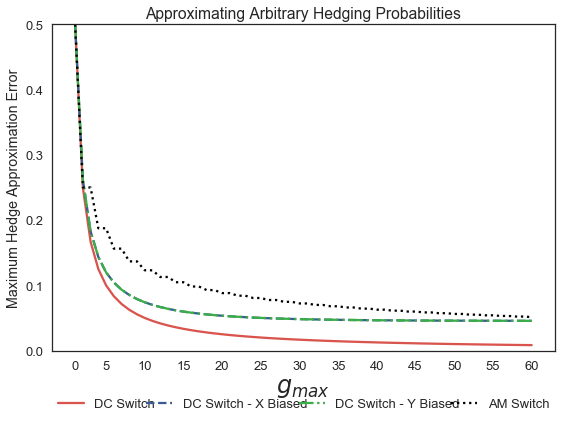

In [7]:
#==============================================================================#
# Fig 4.3
#==============================================================================#
max_gm = 61
diffs = [[],[],[],[]] #DC, DCx, DCy, AM
DC = hedges.get_DC_hedge(1.0,1.0)
DCx = hedges.get_DC_hedge(1.1,1.0)
DCy = hedges.get_DC_hedge(1.0,1.1)
for g_max in range(1, max_gm):
    pmdc, pmx, pmy,pmam = 0.0, 0.0 ,0.0, 0.0 
    for g in range(0,g_max):
        pmdc = max(pmdc, DC(g+1,g_max)-DC(g, g_max))
        pmx  = max(pmx, DCx(g+1,g_max)-DCx(g, g_max))
        pmy  = max(pmy, DCy(g+1,g_max)-DCy(g, g_max))
        pmam = max(pmam, AM_hedge(g+1,g_max)-AM_hedge(g, g_max))

    diffs[0].append(0.5*pmdc)
    diffs[1].append(0.5*pmx)
    diffs[2].append(0.5*pmy)
    diffs[3].append(0.5*pmam)

plt.figure(figsize=(9,6))
plt.plot(range(max_gm-1),diffs[0], color=sbn.xkcd_rgb["pale red"], 
         ls = linestyles[0], label="DC Switch")
plt.plot(diffs[1], color=sbn.xkcd_rgb["denim blue"], 
         ls = linestyles[1], label="DC Switch - X Biased")
plt.plot(diffs[2], color=sbn.xkcd_rgb["medium green"], 
         ls = linestyles[2], label = "DC Switch - Y Biased")
plt.plot(diffs[3], color=sbn.xkcd_rgb["black"], 
         ls = linestyles[3], label = "AM Switch")

plt.xticks(range(max_gm-1), 
           [str(0)]+[str(i) if i%5==0 else '' for i in range(2,max_gm)], 
           rotation='horizontal')

plt.ylim(0,0.5)
plt.xlabel(r'$g_{max}$', fontsize=24)
plt.ylabel('Maximum Hedge Approximation Error')
plt.title('Approximating Arbitrary Hedging Probabilities')

plt.legend(bbox_to_anchor=(0., -0.2, 1., .102), loc=4,
    ncol= 4 , mode="expand", borderaxespad=0.)

plt.show()


## Redundancy - Section 4.3.3
In redundancy.py the extended DC networks from Figure 4.4(A) are defined. The dynamics of these reaction networks are as follows. Note that the 'switched' criterion for these switches is $x+x'=0$ or $x+x'=60$ and so in the following plots the final value of $x$ can differ between stochastic realisations.

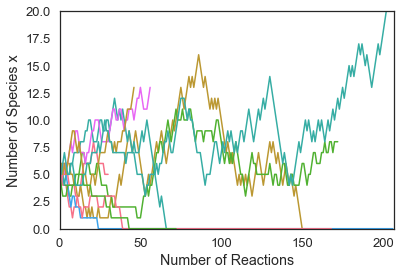

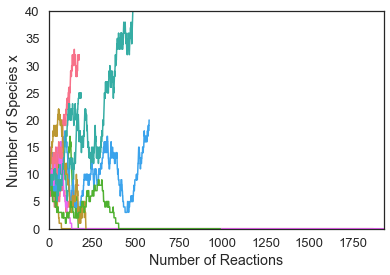

In [8]:
import redundancy as rd
#Note - these are not oscillatory
rd.DCred.generateStochasticPlot('x', 10)
rd.DCnoy.generateStochasticPlot('x',10)

## Invasion Dynamics - Section 4.5
The code in invasion.py contains the calculation of invasion probabilities from the population dynamics. This file also contains the code necessary to generate the associated figures.

In [9]:
#==============================================================================#
# Section 4.5
#==============================================================================#
import invasion as inv
#Parameters
w = [2.0,1.01] #Section 4.5.3

#Example use
M = inv.get_M(0.5,w) #population dynamics matrix for a 50/50 hedging population
print "The population dynamics matrix: ", M

#Properties of growth from the Perron-Frobenius theroem
growth_rate, stationary_dist = inv.get_lambda_v(M) 
print "The exponential growth rate: ", growth_rate
print "The stationary phenotype distribution: ", stationary_dist.flatten()

# p*w[0] + (1-p)*w[1] (avg fitness, equal to the growth rate derived above)
print "Avg. fitness: ", inv.get_avg_fitness(0.5, w) 

#The invasion probability for an invading bet-hedging population
p1, p2 = 0.5, 0.6
inv_p = inv.find_invasion_prob(p1, p2, w)
print "p2 invades p1 with likelihood: ", inv_p
inv_p = inv.find_invasion_prob(p2, p1, w)
print "p1 invades p2 with likelihood: ", inv_p

The population dynamics matrix:  [[ 1.     1.   ]
 [ 0.505  0.505]]
The exponential growth rate:  1.505
The stationary phenotype distribution:  [[ 0.66445183  0.33554817]]
Avg. fitness:  1.505
p2 invades p1 with likelihood:  0.111012149935
p1 invades p2 with likelihood:  0.0


Figures 4.5 and 4.6 are compiled from the above functions. The implementation details for the following methods are presented in invasion.py:

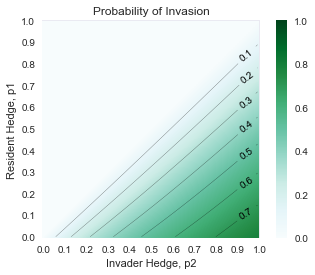

In [10]:
#==============================================================================#
#Figure 4.5
#==============================================================================#
sns.set_style('dark')
inv.pairwise_invasion_plot(w)

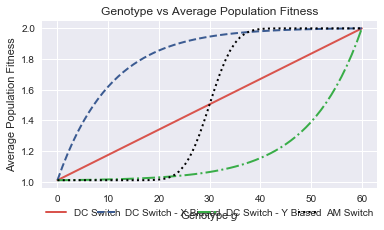

In [11]:
#==============================================================================#
#Fig 4.6(A)
#==============================================================================#
plt.figure(figsize=(10,10))
inv.g_vs_avgf_curve(60, w, [DC_hedge, DC_hedge_x, DC_hedge_y, AM_hedge],
                    switchlabs, linecols, linestyles) #Fig 4.6(A)

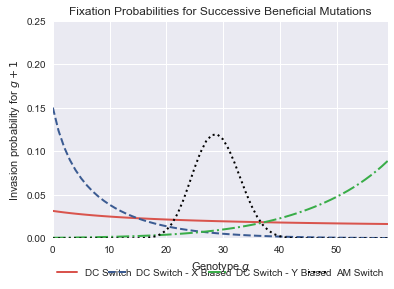

In [21]:
#==============================================================================#
#Fig 4.6(B)
#==============================================================================#
inv.diminishing_returns_plot(w,60,[DC_hedge, DC_hedge_x, DC_hedge_y, AM_hedge], 
                             switchlabs,
                             linecols, linestyles)

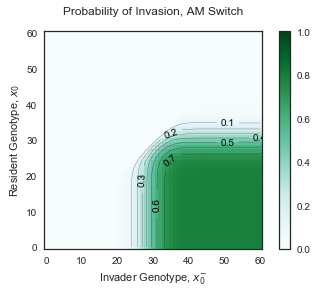

In [13]:
#==============================================================================#
#Fig 4.6(C) - AM example
#==============================================================================#
inv.genotype_invasion_plot(AM_hedge, w, 60, "AM Switch")

## Evolutionary Convergence - Section 4.5.3
convergence.py contains the methods used to simulate evolutionary convergence. 

In [14]:
import convergence as cnv
#==============================================================================#
#Example use - the expected convergence times in mutational events
#
# These values are determined by GetExpectedGenotype in Algorithm 2.
#==============================================================================#
print cnv.expected_convergence_time(30, w, DC_hedge)
print cnv.expected_convergence_time(7, w, DC_hedge_x)
print cnv.expected_convergence_time(53, w, DC_hedge_y)
print cnv.expected_convergence_time(30, w, AM_hedge) 

3382.81556781
66800.1082291
195.818877031
2559425135.59


In [15]:
#==============================================================================#
# The stochastic convergence curves are generated by the following method.
# The results are saved in './Convergence.py'
#==============================================================================#
cnv.convergence_curves(w,30) #Slow

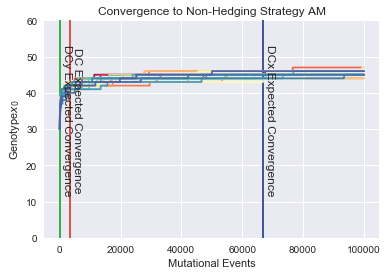

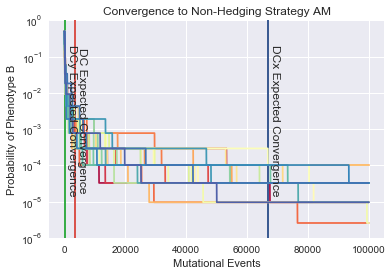

In [22]:
#==============================================================================#
# The curves can be plotted as follows (Fig 4.8(D)) (Uncomment for figs)
#==============================================================================#
# cnv.convergence_plot_g('AM')
# cnv.convergence_plot('AM')

## Treatment Simulation - Section 4.6
Chapter 4 concludes with an exploration of treatment holidays. The code used to generate these results is presented in treatment.py.

In [17]:
#Parameters for the treatment sim
# Cytotoxic
fA,fB = 1.0,0.015
dA,dB = 0.8, 0.005

# Cytostatic
# fA,fB = 0.000,0.015
# dA,dB = 0.005, 0.005

# Mixed
# fA,fB = 0.50,0.015
# dA,dB = 0.40, 0.005

In [18]:
import treatment as trt

In [19]:
#Insure the appropriate directories exit.
!mkdir -p 'HistData'
!mkdir -p 'HistData/cytotoxic'
path = "./HistData/cytotoxic/"

#==============================================================================#
# The following code generates the histogram data but is *very* unoptimised and 
# slow  (multiple hours running time for a large number of samples.)
#==============================================================================#
trials = 2000
hedges = [AM_hedge, DC_hedge, DC_hedge_x, DC_hedge_y]
h_names = ["AM", "DC", "DCx", "DCy"]
g0s = [30,30,7,53]
for h_index in range(0,4):
    print "Calculating histogram for map: ", h_names[h_index]
    trt.generate_histogram_data([2.0,1.01], hedges[h_index], 
                                g0s[h_index], trials, h_names[h_index], path)


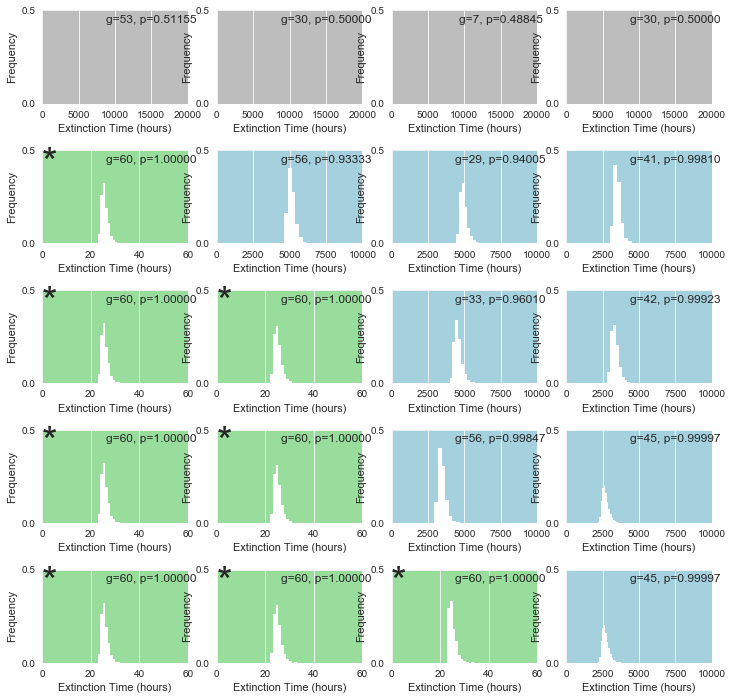

In [24]:
#==============================================================================#
# Figures 4.10 - 4.12 are produced as follows
# Some minor adjustments in shape/size may be needed.
#==============================================================================#
trt.build_figure(path)